# Problem Statement
We aim to predict loan repayment status to assist the company in identifying potential defaulters. A robust model will contribute to minimizing financial risks and optimizing lending decisions. By identifying potential defaulters in advance, the company can make informed decisions regarding loan approvals and set appropriate interest rates.

This problem is a binary classification task, where the goal is to predict the binary outcome of whether a loan will be charged off (1) or fully paid (0).

Source of  data: https://www.kaggle.com/datasets/joebeachcapital/loan-default

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

In [2]:
# Load dataset
df = pd.read_csv("Anonymize_Loan_Default.csv", encoding='latin1')
df.head(3)

"""We load the dataset that we aim to analyze and view the firth 3 rows to have a glimpse of the data."""

'We load the dataset that we aim to analyze and view the firth 3 rows to have a glimpse of the data.'

# Data Preprocessing and Feature Engineering

In [3]:
# Drop irrelevant columns
df = df.drop(['Unnamed: 0','id', 'member_id', 'emp_length', 'issue_d', 'revol_util', 'zip_code', 'addr_state', 'earliest_cr_line', 'mths_since_last_delinq', 'last_pymnt_d', 'next_pymnt_d'], axis=1)

df.dropna(inplace=True)

"""This code removes rows with missing values. Incomplete data can lead to biased model training, and removing rows is a straightforward strategy for handling missing data."""

'This code removes rows with missing values. Incomplete data can lead to biased model training, and removing rows is a straightforward strategy for handling missing data.'

In [5]:
# Split into training, validation and testing sets
df_train, df_test = train_test_split(df, test_size =0.2)
df_train, df_val = train_test_split(df_train, test_size=0.1)

# Define features (X) and target variable (y) for training, validation, and testing sets
X_train = df_train.drop('repay_fail', axis=1)
y_train = df_train['repay_fail']

X_val = df_val.drop('repay_fail', axis=1)
y_val = df_val['repay_fail']

X_test = df_test.drop('repay_fail', axis=1)
y_test = df_test['repay_fail']

"""We split the data into training, validation and test. The validation set is used to tune hyperparameters and prevent overfitting, and the test set is used to evaluate the model's performance on unseen data. The training set is used to train the whole model. After that we identified the target and features of the model and further split them into train, validation and test set.""" 

"We split the data into training, validation and test. The validation set is used to tune hyperparameters and prevent overfitting, and the test set is used to evaluate the model's performance on unseen data. The training set is used to train the whole model. After that we identified the target and features of the model and further split them into train, validation and test set."

In [7]:
# Check shapes
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

""" We check the shape of the training, validation, and test sets for both the feature matrices (X) and target variables (y). This helps check for consistency and avoid errors while while fitting the model later. The results prove that no samples were lost during processing."""

(27699, 24) (27699,)
(3078, 24) (3078,)
(7695, 24) (7695,)


' We check the shape of the training, validation, and test sets for both the feature matrices (X) and target variables (y). This helps check for consistency and avoid errors while while fitting the model later. The results prove that no samples were lost during processing.'

# Vizualization of the data

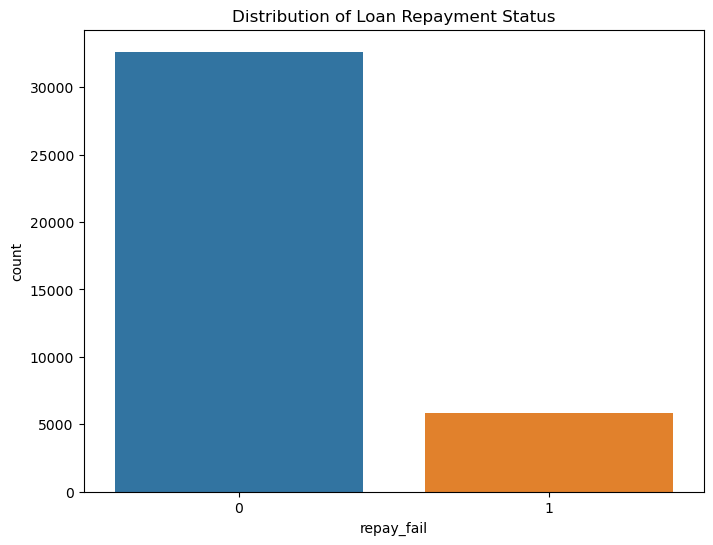

" The graph helps to inform whether it's a balanced or imbalanced classification problem. Our model is imbalanced as the repay is greatly higher than default showing that the model can be biased towards repayment. In this case we need to conisder appropriate performance metrics for the model."

In [8]:
# Analyzing the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='repay_fail', data=df)
plt.title('Distribution of Loan Repayment Status')
plt.show()

""" The graph helps to inform whether it's a balanced or imbalanced classification problem. Our model is imbalanced as the repay is greatly higher than default showing that the model can be biased towards repayment. In this case we need to conisder appropriate performance metrics for the model."""

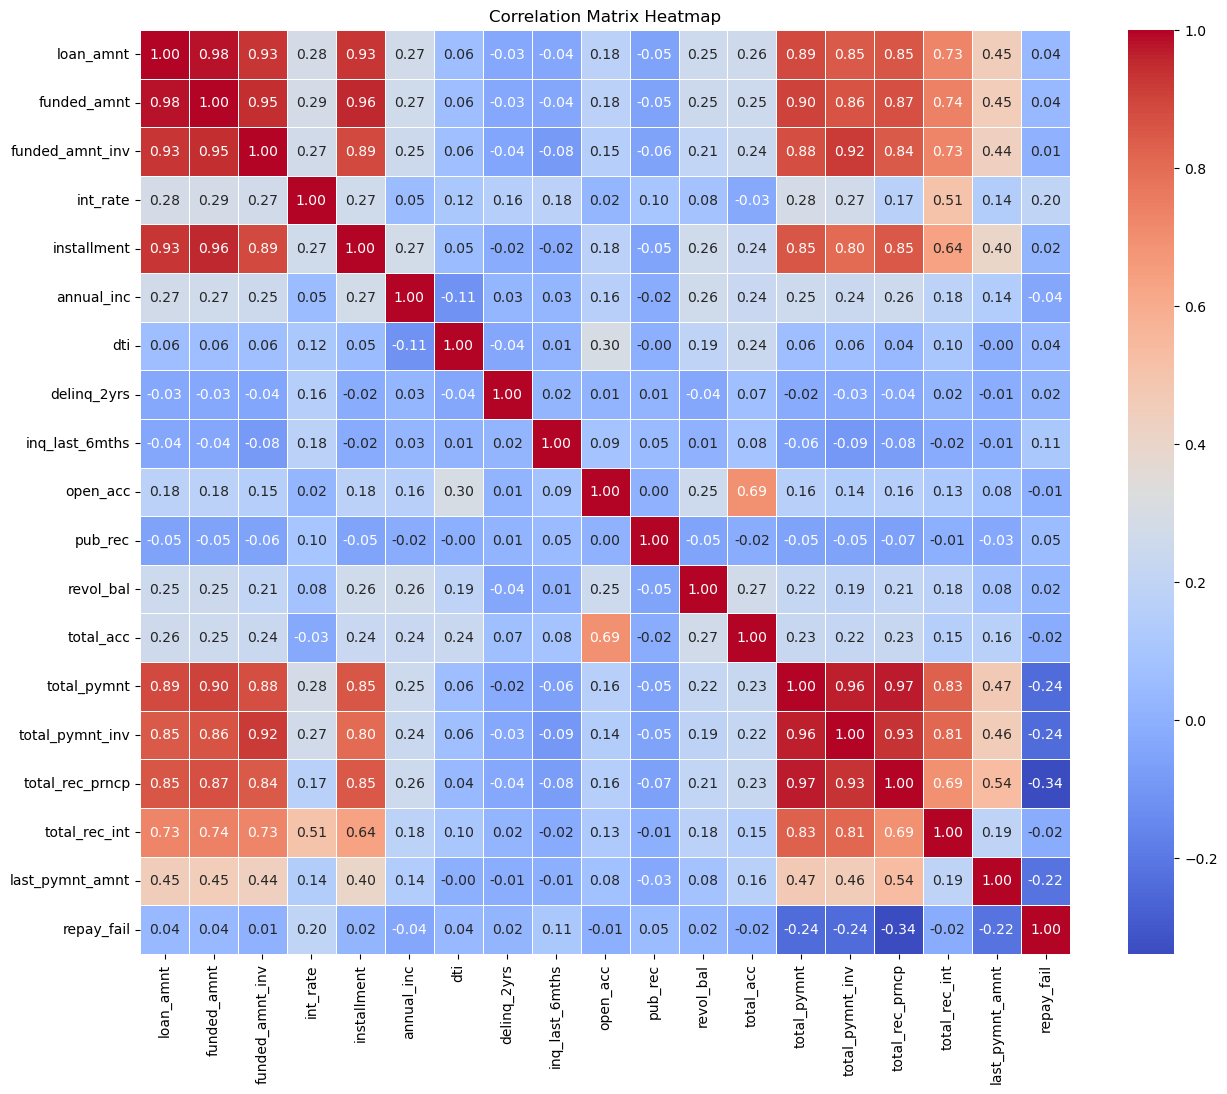

"The correlation matrix helps vizualize highly correlated features in the dataset (anything greater that 0.8). Features with low correlation to the target are less relevant for prediction and won't impact our model. Features with the highest correlation to the target are loan amount, funded amount, funded amount invested, installment, total payment, total payment invested, total principal received to date and total interest received to date."

In [9]:
# Select only numeric columns for correlation matrix
numeric_columns = df_train.select_dtypes(include=np.number)
correlation_matrix = numeric_columns.corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

"""The correlation matrix helps vizualize highly correlated features in the dataset (anything greater that 0.8). Features with low correlation to the target are less relevant for prediction and won't impact our model. Features with the highest correlation to the target are loan amount, funded amount, funded amount invested, installment, total payment, total payment invested, total principal received to date and total interest received to date."""

In [11]:
# Define the categorical and numerical features for column transformation
categorical_features = ['term', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'last_credit_pull_d']
numerical_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
                      'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
                      'revol_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
                      'total_rec_prncp', 'total_rec_int', 'last_pymnt_amnt']

"""We define the categorical and numerical features to help data prepocessing as numerical and categorical features require different means of preprocessing."""

'We define the categorical and numerical features to help data prepocessing as numerical and categorical features require different means of preprocessing.'

In [12]:
# Identify non-numeric columns in numerical features
non_numeric_cols = X_train[numerical_features].select_dtypes(exclude=np.number).columns.tolist()

# Convert non-numeric values to appropriate numeric representations
for col in numerical_features:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Check if there are still non-numeric values
non_numeric_cols_after_conversion = X_train[numerical_features].select_dtypes(exclude=np.number).columns.tolist()
print(non_numeric_cols_after_conversion)

"""Next step is to convert any non-numeric features to numeric in the training, validation, and test sets. This ensures that our model will work well  with prediction as the values are numeric."""

[]


'Next step is to convert any non-numeric features to numeric in the training, validation, and test sets. This ensures that our model will work well  with prediction as the values are numeric.'

In [13]:
# Convert 'term' column to numeric after removing ' months' if it's not already numeric
if X_train['term'].dtype == 'object':
    X_train['term'] = pd.to_numeric(X_train['term'].str.replace(' months', '', regex=False), errors='coerce')
if X_val['term'].dtype == 'object':
    X_val['term'] = pd.to_numeric(X_val['term'].str.replace(' months', '', regex=False), errors='coerce')
if X_test['term'].dtype == 'object':
    X_test['term'] = pd.to_numeric(X_test['term'].str.replace(' months', '', regex=False), errors='coerce')
    
"""Next step is to convert the term column into numeric by dropping the 'months' string. After conversion of the term column into numeric we check to confirm if it was successfull. This helps our model which needs numerical data as input for analysis."""

"Next step is to convert the term column into numeric by dropping the 'months' string. After conversion of the term column into numeric we check to confirm if it was successfull. This helps our model which needs numerical data as input for analysis."

In [15]:
# Create column transformer with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Fit and transform the preprocessor on the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the validation and test data using the fitted preprocessor
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

"""Next we create a preprocessor that applies StandardScaler to numerical features and OneHotEncoder to categorical features respectively. We apply it to the training, validation and test set to to prepare the data for our machine learning model which requires numerical data."""

'Next we create a preprocessor that applies StandardScaler to numerical features and OneHotEncoder to categorical features respectively. We apply it to the training, validation and test set to to prepare the data for our machine learning model which requires numerical data.'

In [16]:
# Create an encoder object with handle_unknown='ignore'
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the training data
encoder.fit(X_train[categorical_features])

# Transform the training, vaidation and test data
X_train_preprocessed_cat = encoder.transform(X_train[categorical_features])
X_val_preprocessed_cat = encoder.transform(X_val[categorical_features])
X_test_preprocessed_cat = encoder.transform(X_test[categorical_features])

"""After creating a column transformer we preprocess categorical features using OneHotEncoder. OneHotEncoder is used convert categorical features into numerical, making them suitable for our machine learning model which works only with numerical data. We apply OneHotEncoder across the training, validation and test set to ensure it's applied evenly."""

"After creating a column transformer we preprocess categorical features using OneHotEncoder. OneHotEncoder is used convert categorical features into numerical, making them suitable for our machine learning model which works only with numerical data. We apply OneHotEncoder across the training, validation and test set to ensure it's applied evenly."

In [17]:
# Ensure that the transformed categorical features are concatenated with numerical features
X_train_preprocessed = np.concatenate([X_train_preprocessed_cat.toarray(), X_train[numerical_features]], axis=1)
X_val_preprocessed = np.concatenate([X_val_preprocessed_cat.toarray(), X_val[numerical_features]], axis=1)
X_test_preprocessed = np.concatenate([X_test_preprocessed_cat.toarray(), X_test[numerical_features]], axis=1)

"""The aim of this code is to create a single preprocessed dataset that includes both the transformed categorical features and the original numerical features using the np.concatenate function on the training, validation and test set. This enables our model learn effectively.""" 

'The aim of this code is to create a single preprocessed dataset that includes both the transformed categorical features and the original numerical features using the np.concatenate function on the training, validation and test set. This enables our model learn effectively.'

In [19]:
# Check the shape of the preprocessed data
print(X_train_preprocessed.shape)
print(X_val_preprocessed.shape)

"""Next we check the shape of the preprocessed data to ensure that the preprocessing steps have been applied correctly and consistently to both the training and validation datasets. The shape of our preprocessed training data has 27699 samples and 158 features while the preprocessed validation data has 3078 samples and 158 features which is favourable as the number of features is the same both in the training and validation set."""

(27699, 159)
(3078, 159)


'Next we check the shape of the preprocessed data to ensure that the preprocessing steps have been applied correctly and consistently to both the training and validation datasets. The shape of our preprocessed training data has 27699 samples and 158 features while the preprocessed validation data has 3078 samples and 158 features which is favourable as the number of features is the same both in the training and validation set.'

In [24]:
# Check for imbalance in our data
# Count the occurrences of each class in the target variable
class_counts = np.bincount(y_train)

# Calculate the proportion of each class
class_proportions = class_counts / len(y_train)

# Print the class imbalance information
for class_label, count, proportion in zip(range(len(class_counts)), class_counts, class_proportions):
    print(f"Class {class_label}: Count = {count}, Proportion = {proportion:.4f}")
    
""" Since we are performing a binary classifiaction we check for class imbalance in the target variable. The results show that class 0 has a count of 23570 samples, accounting for approximately 85.09% of the total samples in y_train while Class 1 has a count of 4129 samples, accounting for approximately 14.91% of the total samples. From the results it's very clear that there's an imbalance in our data. This check helps avoid biased and inaccurate predictions from our machine learning model."""

Class 0: Count = 23570, Proportion = 0.8509
Class 1: Count = 4129, Proportion = 0.1491


" Since we are performing a binary classifiaction we check for class imbalance in the target variable. The results show that class 0 has a count of 23570 samples, accounting for approximately 85.09% of the total samples in y_train while Class 1 has a count of 4129 samples, accounting for approximately 14.91% of the total samples. From the results it's very clear that there's an imbalance in our data. This check helps avoid biased and inaccurate predictions from our machine learning model."

In [25]:
# Check the class distribution in each dataset
train_class_counts = y_train.value_counts()
val_class_counts = y_val.value_counts()
test_class_counts = y_test.value_counts()

# Print the class counts
print("Training Set Class Distribution:")
print(train_class_counts)
print("\nValidation Set Class Distribution:")
print(val_class_counts)
print("\nTesting Set Class Distribution:")
print(test_class_counts)

""" Based on the above resluts we check the class distribution across the training, validation, and testing sets to check for class imbalance. The reulsts show that class 0 (repaying loans successfully) is significantly overrepresented compared to class 1 (repaying loans unsuccessfully) in all three datasets. This suggests that the class imbalance is a consistent issue across the entire dataset. We proceed to tackle this in the next step."""

Training Set Class Distribution:
0    23570
1     4129
Name: repay_fail, dtype: int64

Validation Set Class Distribution:
0    2579
1     499
Name: repay_fail, dtype: int64

Testing Set Class Distribution:
0    6497
1    1198
Name: repay_fail, dtype: int64


' Based on the above resluts we check the class distribution across the training, validation, and testing sets to check for class imbalance. The reulsts show that class 0 (repaying loans successfully) is significantly overrepresented compared to class 1 (repaying loans unsuccessfully) in all three datasets. This suggests that the class imbalance is a consistent issue across the entire dataset. We proceed to tackle this in the next step.'

In [26]:
# Perform oversampling using SMOTE on the preprocessed training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

""" We proceed with SMOTE which is an oversampling technique used to balance class distribution by generating synthetic samples for the minority class creating a more balanced training dataset."""

' We proceed with SMOTE which is an oversampling technique used to balance class distribution by generating synthetic samples for the minority class creating a more balanced training dataset.'

In [31]:
# Check for class imbalance after oversampling
class_counts_resampled = y_train_resampled.value_counts()
print("Class distribution after oversampling:")
print(class_counts_resampled)

"""We check and display the class distribution after oversampling to confirm if SMOTE addresses the oversampling. The results show that oversampling in class 1 and class 0 was addressed and are now equal at 23570 respectively."""

Class distribution after oversampling:
0    23570
1    23570
Name: repay_fail, dtype: int64


'We check and display the class distribution after oversampling to confirm if SMOTE addresses the oversampling. The results show that oversampling in class 1 and class 0 was addressed and are now equal at 23570 respectively.'

In [33]:
# Initialize the MLPClassifier with sigmoid activation function and adam solver
mlp_best = MLPClassifier(activation='logistic', solver='adam', max_iter=100, warm_start=True, validation_fraction=0.1, early_stopping=False)

n_epochs = 200
best_validation_score = 0
best_epoch = 0
validation_scores = []  
no_improvement_count = 0
early_stopping_patience = 10  

for epoch in range(n_epochs):
    mlp_best.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the validation set
    y_pred_val = mlp_best.predict(X_val_preprocessed)
    
    # Evaluate accuracy on the validation set
    validation_score = accuracy_score(y_val, y_pred_val)
    validation_scores.append(validation_score)
    
    # Check if the current epoch has the best validation score
    if validation_score > best_validation_score:
        best_validation_score = validation_score
        best_epoch = epoch + 1  
        no_improvement_count = 0  
    else:
        no_improvement_count += 1  
    
    print(f"Epoch {epoch+1}, Validation Score: {validation_score}, Best Validation Score: {best_validation_score} at Epoch {best_epoch}")
    
    # Check for early stopping
    if no_improvement_count >= early_stopping_patience:
        print(f"Early stopping at Epoch {epoch+1} as there is no improvement for {early_stopping_patience} epochs.")
        break

print(f"Final Best Validation Score: {best_validation_score} at Epoch {best_epoch}")

""" Our model uses multi-layer perceptron classifier as it captures non-linear relationships between features and target variables like our loan repayment dataset and it can capture temporal relationships thus helping in identifying trends and patterns that could influence loan repayment outcomes. 
activation='logistic. It uses logistic sigmoid activation function which is conducive for binary classification tasks.
solver='adam. We use the Adam optimizer which is sufficient for training deep neural networks.
max_iter=100. We set the maximum iterations at 100 to avoid  long training times and overfitting.
warm_start=True. We set it to reduce training time by saving each state after each epoch.
validation_fraction=0.1. The validation fraction is set at 10% to monitor the model's performance during training.
early_stopping=False is disabled but it will be activated based on the model's performance.
n_epochs=200. This is the total number of epochs the model will run. It will stop running if validation performance doesn't improve for 10 consecutive epochs.
best_validation_score. Stores the highest validation accuracy achieved during training
best_epoch: Identifies the epoch at which the highest validation accuracy was achieved
validation_scores: Tracks the validation accuracy at each epoch
no_improvement_count: Keeps track of the number of consecutive epochs without improvement in validation accuracy
early_stopping_patience=10: If validation accuracy doesn't improve for 10 consecutive epochs, early stopping is triggered and the training stops.
break: Exits the training loop if early stopping is triggered."""

Epoch 1, Validation Score: 0.9740090968161144, Best Validation Score: 0.9740090968161144 at Epoch 1
Epoch 2, Validation Score: 0.9840805717998701, Best Validation Score: 0.9840805717998701 at Epoch 2
Epoch 3, Validation Score: 0.98635477582846, Best Validation Score: 0.98635477582846 at Epoch 3
Epoch 4, Validation Score: 0.9873294346978557, Best Validation Score: 0.9873294346978557 at Epoch 4
Epoch 5, Validation Score: 0.9902534113060428, Best Validation Score: 0.9902534113060428 at Epoch 5
Epoch 6, Validation Score: 0.98635477582846, Best Validation Score: 0.9902534113060428 at Epoch 5
Epoch 7, Validation Score: 0.9801819363222872, Best Validation Score: 0.9902534113060428 at Epoch 5
Epoch 8, Validation Score: 0.9879792072774529, Best Validation Score: 0.9902534113060428 at Epoch 5
Epoch 9, Validation Score: 0.9743339831059129, Best Validation Score: 0.9902534113060428 at Epoch 5
Epoch 10, Validation Score: 0.9769330734243015, Best Validation Score: 0.9902534113060428 at Epoch 5
Epoch

" Our model uses multi-layer perceptron classifier as it captures non-linear relationships between features and target variables like our loan repayment dataset and it can capture temporal relationships thus helping in identifying trends and patterns that could influence loan repayment outcomes. \nactivation='logistic. It uses logistic sigmoid activation function which is conducive for binary classification tasks.\nsolver='adam. We use the Adam optimizer which is sufficient for training deep neural networks.\nmax_iter=100. We set the maximum iterations at 100 to avoid  long training times and overfitting.\nwarm_start=True. We set it to reduce training time by saving each state after each epoch.\nvalidation_fraction=0.1. The validation fraction is set at 10% to monitor the model's performance during training.\nearly_stopping=False is disabled but it will be activated based on the model's performance.\nn_epochs=200. This is the total number of epochs the model will run. It will stop runn

In [19]:
# Evaluate other metrics using classification_report
classification_rep = classification_report(y_val, y_pred_val)

print("Validation Set Classification Report:\n", classification_rep)

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2619
           1       0.86      0.97      0.91       459

    accuracy                           0.97      3078
   macro avg       0.93      0.97      0.95      3078
weighted avg       0.97      0.97      0.97      3078



In [20]:
# Evaluate other metrics such as precision, recall, and F1 score for the validation set
val_precision = precision_score(y_val, y_pred_val)
val_recall = recall_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val)

print(f"Validation Set Precision: {val_precision}")
print(f"Validation Set Recall: {val_recall}")
print(f"Validation Set F1 Score: {val_f1}")

Validation Set Precision: 0.8607350096711799
Validation Set Recall: 0.9694989106753813
Validation Set F1 Score: 0.9118852459016393


In [21]:
# Evaluate on the test set
y_pred_test = mlp_best.predict(X_test_preprocessed)
test_score = accuracy_score(y_test, y_pred_test)
print(f"Test Set Accuracy: {test_score}")

Test Set Accuracy: 0.9723196881091618


In [22]:
# Evaluate other metrics using classification_report
classification_rep = classification_report(y_test, y_pred_test)

print("Test Set Classification Report:\n", classification_rep)

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      6546
           1       0.86      0.97      0.91      1149

    accuracy                           0.97      7695
   macro avg       0.93      0.97      0.95      7695
weighted avg       0.97      0.97      0.97      7695



In [23]:
# You can also evaluate other metrics such as precision, recall, and F1 score for the test set
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print(f"Test Set Precision: {test_precision}")
print(f"Test Set Recall: {test_recall}")
print(f"Test Set F1 Score: {test_f1}")

Test Set Precision: 0.8627906976744186
Test Set Recall: 0.9686684073107049
Test Set F1 Score: 0.9126691266912669
